In [91]:
import pandas as pd
import re

In [92]:
def load_and_merge_mut_rsa(
    mutation_csv,
    rsa_csv,
    gene_name,
    check_aa_match=True
):
    """
    Load mutation and RSA files for a single gene and merge on residue position.
    """

    # Load data
    mut = pd.read_csv(mutation_csv)
    rsa = pd.read_csv(rsa_csv)

    # Drop duplicated mutations
    mut = mut.drop_duplicates(subset=["Mutation"])

    # Extract residue position (e.g. R35Q -> 35)
    mut["Position"] = mut["Mutation"].str.extract(r"(\d+)").astype(int)

    # Rename amino acid columns
    mut = mut.rename(columns={
        "aaref": "WT_AA",
        "aaalt": "Mut_AA"
    })

    rsa = rsa.rename(columns={"ResNum": "Position"})

    # Merge
    merged = mut.merge(
        rsa[["Position", "AA", "RSA"]],
        on="Position",
        how="left"
    )

    # Add gene label
    merged["Gene"] = gene_name

    # Optional amino-acid consistency check
    if check_aa_match:
        merged["AA_match"] = merged["WT_AA"] == merged["AA"]

    return merged


def summarize_by_amino_acid(merged_df):
    """
    Summarize RSA statistics by wild-type amino acid.
    """

    summary = (
        merged_df
        .groupby("WT_AA")
        .agg(
            n=("Mutation", "count"),
            mean_RSA=("RSA", "mean"),
            median_RSA=("RSA", "median"),
            min_RSA=("RSA", "min"),
            max_RSA=("RSA", "max")
        )
        .reset_index()
        .sort_values("WT_AA")
    )

    return summary


In [93]:
# ---- Gene label ----
GENE_NAME = "PSEN1_Sun"

# ---- File paths ----
MUTATION_FILE = "../raw_data/PSEN1_Sun.csv"
RSA_FILE = "../processed_data/PSEN1_AF3_RSA.csv"

In [94]:
# # ---- Gene label ----
# GENE_NAME = "PSEN1_Petit"

# # ---- File paths ----
# MUTATION_FILE = "../raw_data/PSEN1_Petit.csv"
# RSA_FILE = "../processed_data/PSEN1_AF3_RSA.csv"

In [95]:
# # ---- Gene label ----
# GENE_NAME = "PSEN1_Pillai"

# # ---- File paths ----
# MUTATION_FILE = "../raw_data/PSEN1_Pillai.csv"
# RSA_FILE = "../processed_data/PSEN1_AF3_RSA.csv"

In [96]:
# # ---- Gene label ----
# GENE_NAME = "PSEN2_Pillai"

# # ---- File paths ----
# MUTATION_FILE = "../raw_data/PSEN2_Pillai.csv"
# RSA_FILE = "../processed_data/PSEN2_AF3_RSA.csv"

In [97]:
# # ---- Gene label ----
# GENE_NAME = "APP_Pillai"

# # ---- File paths ----
# MUTATION_FILE = "../raw_data/APP_Pillai.csv"
# RSA_FILE = "../processed_data/APP_AF3_RSA.csv"

In [98]:
merged = load_and_merge_mut_rsa(
    mutation_csv=MUTATION_FILE,
    rsa_csv=RSA_FILE,
    gene_name=GENE_NAME
)

merged.head()


,Variants,Mutation,AAO,Total Activity,SD of Total Activity,Ab42/Ab40 ratio,SD of ratio,Amount of Ab40,SD of Ab40,Amount of Ab42,...,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,Position,AA,RSA,Gene,AA_match
0,PSEN1:p.Arg35Gln,R35Q,59.0,0.430,0.031,1.449,0.267,0.423,0.032,0.673,...,0.16279,0.839981,-0.500256,0.21837,1.201499,35,R,0.751,PSEN1_Sun,True
1,PSEN1:p.Ala79Val,A79V,61.2,0.013,0.002,NaN,NaN,0.008,0.001,0.056,...,0.88323,9.558504,0.766865,0.87344,9.212799,79,A,0.421,PSEN1_Sun,True
2,PSEN1:p.Val82Leu,V82L,55.0,0.596,0.018,0.813,0.070,0.608,0.016,0.516,...,0.91712,11.048510,0.847559,0.92834,11.683780,82,V,0.194,PSEN1_Sun,True
3,PSEN1:p.Leu85Pro,L85P,26.0,0.020,0.001,NaN,NaN,0.011,0.001,0.177,...,0.92061,11.235850,0.825157,0.91439,10.910840,85,L,0.005,PSEN1_Sun,True
4,PSEN1:p.Val89Leu,V89L,48.6,0.188,0.009,2.526,0.235,0.162,0.006,0.417,...,0.95941,14.151250,0.930148,0.96740,15.105730,89,V,0.006,PSEN1_Sun,True


In [99]:
summary_by_aa = summarize_by_amino_acid(merged)
summary_by_aa


,WT_AA,n,mean_RSA,median_RSA,min_RSA,max_RSA
0,A,11,0.175000,0.025,0.000,0.587
1,C,3,0.108000,0.000,0.000,0.324
2,D,1,0.668000,0.668,0.668,0.668
3,E,9,0.329444,0.294,0.051,0.944
4,F,5,0.193800,0.136,0.013,0.504
5,G,9,0.097444,0.031,0.000,0.330
6,H,3,0.264000,0.250,0.139,0.403
7,I,9,0.164333,0.092,0.000,0.574
8,K,1,0.057000,0.057,0.057,0.057
9,L,27,0.152222,0.126,0.000,0.461


In [100]:
low_rsa_aa = summary_by_aa.loc[
    summary_by_aa["mean_RSA"] < 0.25
]

print(f"Amino acids with mean RSA < 0.25 in {GENE_NAME}:")
print(f"Count: {low_rsa_aa.shape[0]}\n")

low_rsa_aa


Amino acids with mean RSA < 0.25 in PSEN1_Sun:
Count: 14



,WT_AA,n,mean_RSA,median_RSA,min_RSA,max_RSA
0,A,11,0.175000,0.025,0.000,0.587
1,C,3,0.108000,0.000,0.000,0.324
4,F,5,0.193800,0.136,0.013,0.504
5,G,9,0.097444,0.031,0.000,0.330
7,I,9,0.164333,0.092,0.000,0.574
8,K,1,0.057000,0.057,0.057,0.057
9,L,27,0.152222,0.126,0.000,0.461
10,M,4,0.230250,0.207,0.074,0.433
11,N,2,0.190000,0.190,0.000,0.380
13,Q,2,0.154000,0.154,0.154,0.154


In [101]:
# merged.to_csv(f"../processed_data/{GENE_NAME}_mutation_RSA_merged.csv", index=False)
summary_by_aa.to_csv(f"../processed_data/{GENE_NAME}_RSA_summary_by_AA.csv", index=False)

In [102]:
# Any mismatches between WT amino acid and RSA AA?
merged.loc[
    merged["AA_match"] == False,
    ["Mutation", "Position", "WT_AA", "AA"]
]

,Mutation,Position,WT_AA,AA
121,A434C,434,NaN,A


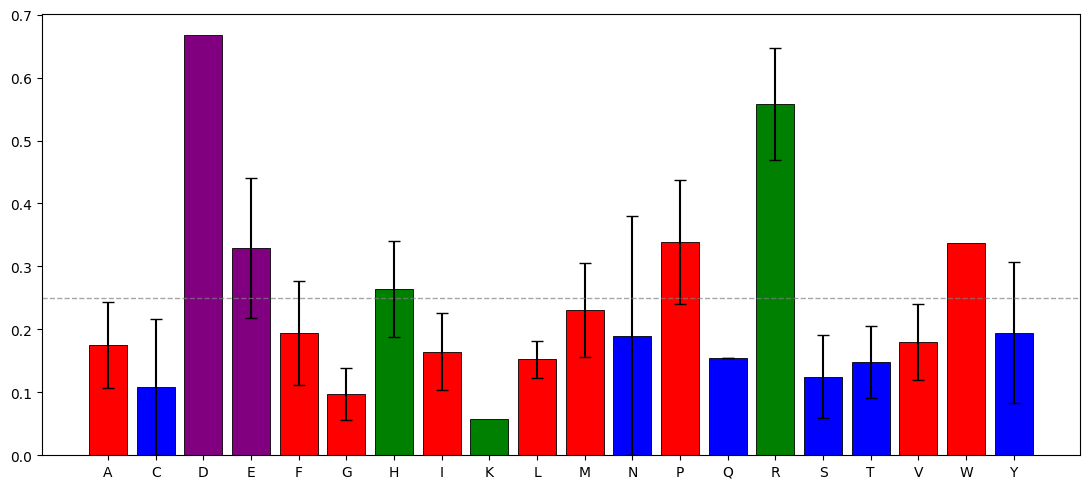

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Amino acid groups
aa_groups = {
    "nonpolar": {
        "aas": ["G", "A", "V", "P", "L", "I", "M", "W", "F"],
        "color": "red"
    },
    "polar": {
        "aas": ["C", "S", "T", "Y", "N", "Q"],
        "color": "blue"
    },
    "negative": {
        "aas": ["D", "E"],
        "color": "purple"
    },
    "positive": {
        "aas": ["K", "R", "H"],
        "color": "green"
    }
}

# Assign color to each amino acid
def aa_to_color(aa):
    for group in aa_groups.values():
        if aa in group["aas"]:
            return group["color"]
    return "gray"

# ---- Aggregate statistics from merged ----
stats = (
    merged
    .groupby("WT_AA")["RSA"]
    .agg(
        mean_RSA="mean",
        std_RSA="std",
        n="count"
    )
    .reset_index()
)

# Standard error
stats["sem_RSA"] = stats["std_RSA"] / np.sqrt(stats["n"])

# Sort amino acids alphabetically (keeps x-axis clean)
stats = stats.sort_values("WT_AA")

# Colors
colors = stats["WT_AA"].apply(aa_to_color)

# ---- Plot ----
plt.figure(figsize=(11, 5))

plt.bar(
    stats["WT_AA"],
    stats["mean_RSA"],
    yerr=stats["sem_RSA"],
    capsize=4,
    color=colors,
    edgecolor="black",
    linewidth=0.6
)

# Optional reference line (buried threshold)
plt.axhline(0.25, linestyle="--", linewidth=1, color="gray", alpha=0.7)

# Labels and title
# plt.xlabel("Amino Acid (WT)")
# plt.ylabel("Mean RSA ± SEM")
# plt.title("Mean RSA by Amino Acid (from Mutations)")

# Legend
legend_handles = [
    plt.Rectangle((0, 0), 1, 1, color="red", label="Non-polar"),
    plt.Rectangle((0, 0), 1, 1, color="blue", label="Polar"),
    plt.Rectangle((0, 0), 1, 1, color="purple", label="Negative charge"),
    plt.Rectangle((0, 0), 1, 1, color="green", label="Positive charge"),
]

plt.tight_layout()
plt.show()